# Srovnání modelů na klasifikaci fotek prostředí

In [61]:
# Importy
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.discriminant_analysis import StandardScaler
import tensorflow as tf
from keras import models, layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from collections import defaultdict

## Dataset

### Načtení dat ze souborů

In [62]:
seg_train = Path.cwd() / "seg_train"
seg_test = Path.cwd() / "seg_test"
x_train = []
y_train = []
x_test = []
y_test = []
img_size = (16,16)
categories = ["buildings", "forest", "glacier", "mountain", "sea", "street"]


for category_idx, category in enumerate(categories):
    for file in os.listdir(os.path.join(seg_train, category)):
        img_path = os.path.join(seg_train, category, file)
        img = imread(img_path)
        x_train.append(img)
        y_train.append(category_idx)
    for file in os.listdir(os.path.join(seg_test, category)):
        img_path = os.path.join(seg_test, category, file)
        img = imread(img_path)
        x_test.append(img)
        y_test.append(category_idx)

### Popis datasetu

V další buňce lze vidět že data jsou relativně rovnoměrně rozdělena, díky tomu je možné bezpečně trénovat model.

In [3]:
print(
    f"""
Počet trénovacích fotek: {len(x_train)}     
Počet testovacích fotek: {len(x_test)}              
Struktura každé fotky: {x_train[0].shape}

Počet výskytů v každé kategorii: {np.unique(y_train, return_counts=True)[1]}
Počet výskytů v každé kategorii: {np.unique(y_test, return_counts=True)[1]}
"""
)


Počet trénovacích fotek: 14034     
Počet testovacích fotek: 3000              
Struktura každé fotky: (150, 150, 3)

Počet výskytů v každé kategorii: [2191 2271 2404 2512 2274 2382]
Počet výskytů v každé kategorii: [437 474 553 525 510 501]



### Ukázka fotek z datasetu

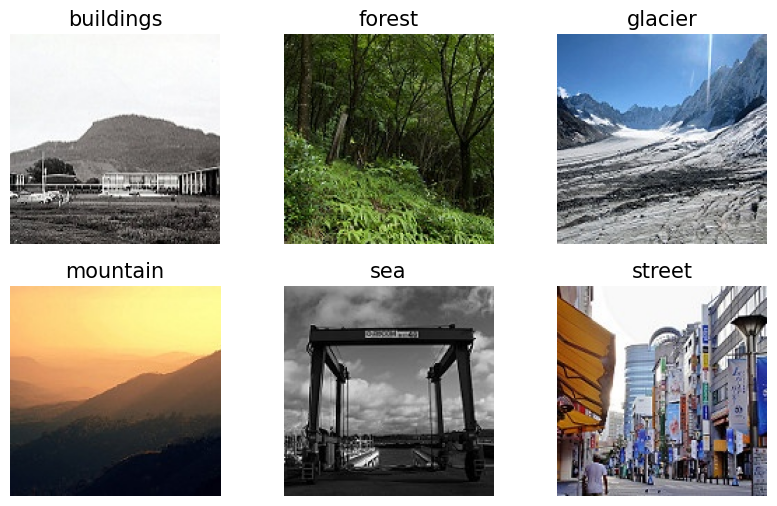

In [63]:
plt.figure(figsize=(10, len(category)))
for category_idx, category in enumerate(categories):
    img_index = y_train.index(category_idx)
    plt.subplot(2,3,category_idx+1)
    plt.imshow(x_train[img_index])
    plt.axis("off")
    plt.title(category, fontsize=15)
plt.show()  

### Finální úprava dat

Je potřeba fotky zmenšit na 32x32 pixelů. Tento krok je převážně kvůli rychlosti trénování modelu, trénování s takovým množstvím fotek o velikostí 150x150 pixelů by nebylo možné v domácích podmínkách.

In [5]:
x_train_models = []
x_test_models = []

for img in x_train:
    resized_img = resize(img, img_size)
    x_train_models.append(resized_img.flatten())

for img in x_test:
    resized_img = resize(img, img_size)
    x_test_models.append(resized_img.flatten())
x_train_models = np.asarray(x_train_models)
y_train_models = np.asarray(y_train)
x_test_models = np.asarray(x_test_models)
y_test_models = np.asarray(y_test)

## Model

### SVM

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END .......C=1, gamma=0.01, kernel=rbf;, score=0.610 total time=  16.7s
[CV 2/2] END .......C=1, gamma=0.01, kernel=rbf;, score=0.607 total time=  16.5s
[CV 1/2] END ........C=1, gamma=0.1, kernel=rbf;, score=0.623 total time=  20.9s
[CV 2/2] END ........C=1, gamma=0.1, kernel=rbf;, score=0.624 total time=  21.9s
[CV 1/2] END ..........C=1, gamma=1, kernel=rbf;, score=0.187 total time=  27.2s
[CV 2/2] END ..........C=1, gamma=1, kernel=rbf;, score=0.187 total time=  27.1s
[CV 1/2] END ......C=10, gamma=0.01, kernel=rbf;, score=0.642 total time=  17.1s
[CV 2/2] END ......C=10, gamma=0.01, kernel=rbf;, score=0.636 total time=  16.6s
[CV 1/2] END .......C=10, gamma=0.1, kernel=rbf;, score=0.624 total time=  23.4s
[CV 2/2] END .......C=10, gamma=0.1, kernel=rbf;, score=0.621 total time=  23.6s
[CV 1/2] END .........C=10, gamma=1, kernel=rbf;, score=0.191 total time=  25.9s
[CV 2/2] END .........C=10, gamma=1, kernel=rbf;,

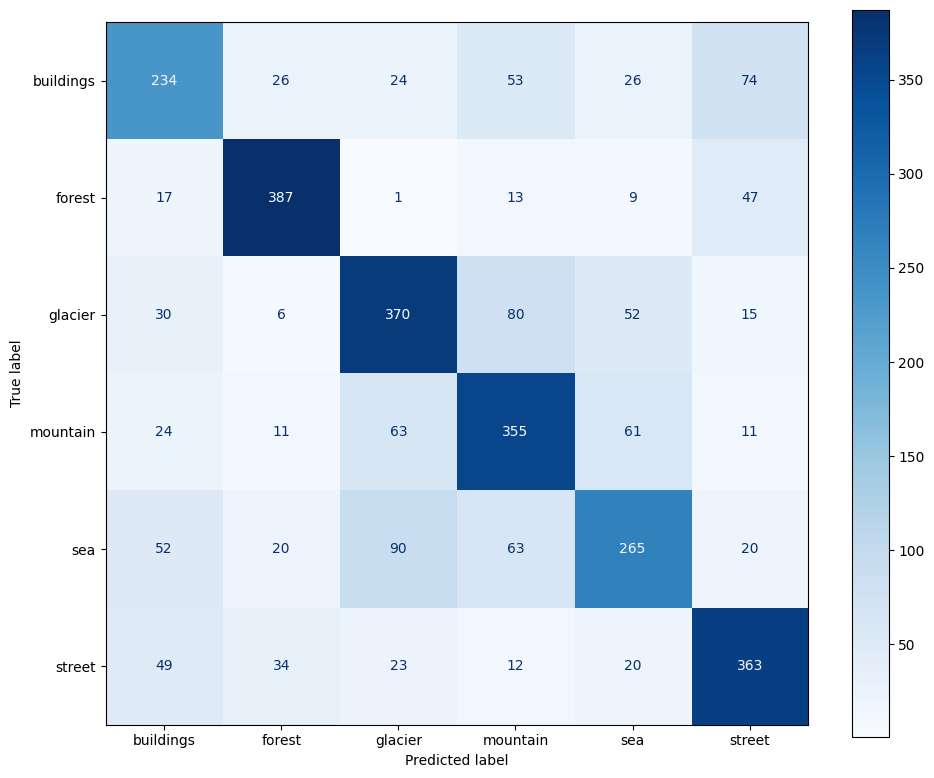

In [64]:
def plot_confusion_matrix(y_test, y_pred):
    print(classification_report(y_test, y_pred, target_names=categories))
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = categories)
    fig, ax = plt.subplots(figsize=(10, 8))
    cm_display.plot(ax=ax, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.show()
    

param_grid = {
    'C': [1, 10, 100],
    'kernel': ["rbf"],
    'gamma': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(SVC(), param_grid,verbose=3, cv=2)
grid_search.fit(x_train_models, y_train_models)
print(f"Nejlépe vycházel model: {grid_search.best_params_}")

y_pred = grid_search.best_estimator_.predict(x_test_models)

plot_confusion_matrix(y_test_models, y_pred)

### Ukázka problematických fotek

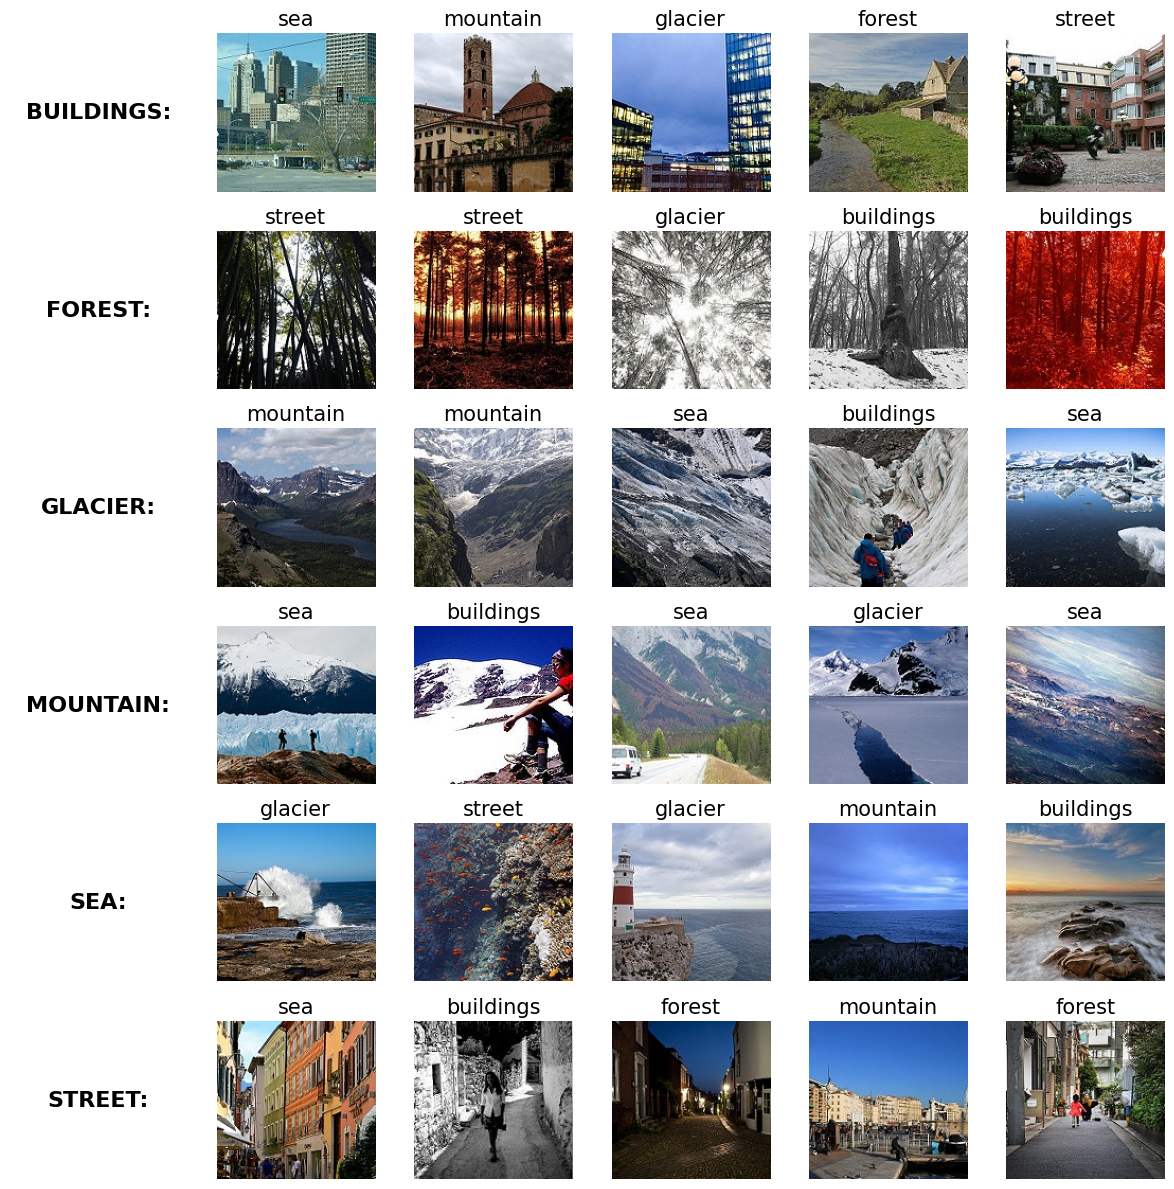

In [65]:
num_images_per_category = 5
images_to_display = {}

for idx in range(len(y_pred)):
    pred = y_pred[idx]
    true_label = y_test_models[idx]
    if pred != true_label:
        if true_label not in images_to_display:
            images_to_display[true_label] = []
        if len(images_to_display[true_label]) < num_images_per_category:
            images_to_display[true_label].append((x_test[idx], pred))

num_rows = len(images_to_display)
num_cols = num_images_per_category

fig, axes = plt.subplots(num_rows, num_cols + 1, figsize=((num_cols + 1) * 2, num_rows * 2))

for row, (category, images) in enumerate(images_to_display.items()):
    axes[row, 0].text(0.5, 0.5, f"{categories[category].upper()}:", rotation=0, ha='center', va='center', fontsize=16, weight='bold')
    axes[row, 0].axis('off')

    for col, (img, pred_label) in enumerate(images):
        ax = axes[row, col + 1]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(categories[pred_label], fontsize=15)

plt.tight_layout()
plt.show()
